# Used car price listing prediction model
This is my very first project. Feedback is much appreciated. :)

## Memory Issue
When I start the modelling/feature engineering process, a lot of extra features get added to the dataset due to adding things like more polynomial degrees. A lot of the time, Kaggle stopped running because I exceeded 30gb of RAM usage in the notebook (with a polynomial degree of 3, the dataset had around 3000 features and over 200,000 samples). I used this thread https://www.kaggle.com/questions-and-answers/301413 to help me solve this issue. It linked me to this https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage/notebook which I copied the code for below.

In [1]:
# Code from https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage/notebook
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import sys

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/inpu~t'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

from pandas.plotting import scatter_matrix

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

%matplotlib inline

## About the dataset
This dataset contains information about used car listings on websites. Because of this, the 'price' feature does not actually mean the price at which the car was sold at. Therefore, what I will be doing is building a model to predict approximately what price the cars should be listed at, not what they actually go for. It also seems like most or all of the entries are from 2016, and so the final target of this model is to predict what price a car should be listed for in 2016. This dataset could be used for more interesting and useful things such as ad or listing information, etc.

## Translations
I tried to translate german terms were not obvious using google translate and images

limousine = sedan  
kleinwagen = compact/smart car  
kombi = van  
cabrio = convertible  
andere = other  


In [4]:
# load the dataset
print('-' * 80)
print('dataset')
dataset = import_data('/kaggle/input/uncovering-factors-that-affect-used-car-prices/autos.csv')
print('-' * 80)

--------------------------------------------------------------------------------
dataset
Memory usage of dataframe is 59.53 MB
Memory usage after optimization is: 46.06 MB
Decreased by 22.6%
--------------------------------------------------------------------------------


In [5]:
# Let's get a look at some basic info of the data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   index                371528 non-null  int32 
 1   dateCrawled          371528 non-null  object
 2   name                 371528 non-null  object
 3   seller               371528 non-null  object
 4   offerType            371528 non-null  object
 5   price                371528 non-null  int64 
 6   abtest               371528 non-null  object
 7   vehicleType          333659 non-null  object
 8   yearOfRegistration   371528 non-null  int16 
 9   gearbox              351319 non-null  object
 10  powerPS              371528 non-null  int16 
 11  model                351044 non-null  object
 12  kilometer            371528 non-null  int32 
 13  monthOfRegistration  371528 non-null  int8  
 14  fuelType             338142 non-null  object
 15  brand                371528 non-nu

In [6]:
dataset.describe(include='all')

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
count,371528.000000,371528,371528,371528,371528,3.715280e+05,371528,333659,371528.000000,351319,371528.000000,351044,371528.000000,371528.000000,338142,371528,299468,371528,371528.0,371528.00000,371528
unique,NaN,280500,233531,2,2,NaN,2,8,NaN,2,NaN,251,NaN,NaN,7,40,2,114,NaN,NaN,182806
top,NaN,2016-03-24 14:49:47,Ford_Fiesta,privat,Angebot,NaN,test,limousine,NaN,manuell,NaN,golf,NaN,NaN,benzin,volkswagen,nein,2016-04-03 00:00:00,NaN,NaN,2016-04-07 06:45:59
freq,NaN,7,657,371525,371516,NaN,192585,95894,NaN,274214,NaN,30070,NaN,NaN,223857,79640,263182,14450,NaN,NaN,17
mean,185763.500000,NaN,NaN,NaN,NaN,1.729514e+04,NaN,NaN,2004.577997,NaN,115.549477,NaN,125618.688228,5.734445,NaN,NaN,NaN,NaN,0.0,50820.66764,NaN
std,107251.039743,NaN,NaN,NaN,NaN,3.587954e+06,NaN,NaN,92.866598,NaN,192.139578,NaN,40112.337051,3.712412,NaN,NaN,NaN,NaN,0.0,25799.08247,NaN
min,0.000000,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.00000,NaN
25%,92881.750000,NaN,NaN,NaN,NaN,1.150000e+03,NaN,NaN,1999.000000,NaN,70.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30459.00000,NaN
50%,185763.500000,NaN,NaN,NaN,NaN,2.950000e+03,NaN,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49610.00000,NaN
75%,278645.250000,NaN,NaN,NaN,NaN,7.200000e+03,NaN,NaN,2008.000000,NaN,150.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71546.00000,NaN


## Data Preprocessing
Here I will go through outliers, formats, and splitting the data

In [7]:
# Remove price's that are 0, cars that have a year older than 1930 or newer than 2016 (this dataset was scraped in 2016), remove all cars with powerPS below 10 and above 600 with price under 60,000 (then take a closer look at the rest later), 
dataset = dataset[dataset['price'] > 0]
dataset = dataset[(dataset['yearOfRegistration'] > 1930) & (dataset['yearOfRegistration'] < 2016)]
dataset = dataset[(dataset['powerPS'] > 10)]

In [8]:
dataset.shape

(306477, 21)

In [9]:
# Only want cars that are over 600 PS with a price over 60,000
newdf = dataset.copy()
newdf = newdf[(newdf['powerPS'] > 600) & (newdf['price'] > 60000)]

In [10]:
# Concat newdf and df
dataset = dataset[dataset['powerPS'] < 600]
dataset = pd.concat([dataset, newdf], axis=0)

### Outliers

Before I split the data, I will investigate outliers in most of the columns, and decide to either remove or keep them depending on my judgement of the origin for them.
'price' has some extremely low values (i.e 0 and 1), so I will look into these. I doubt any car really goes for 0 or 1 euros, so most likely I will be removing them. Nevertheless, let's find these cars.

In [11]:
# Function to plot histogram on log scale
# Non-equal bin sizes, that will look equal on log scale
# x = data
def loghist(x, bins, subplot):
    logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
    plt.subplot(subplot)
    plt.hist(x, bins=logbins)
    plt.title(f"{x.name} distribution")
    plt.xscale('log')
    plt.xlabel(f"{x.name} (log)")
    plt.show()

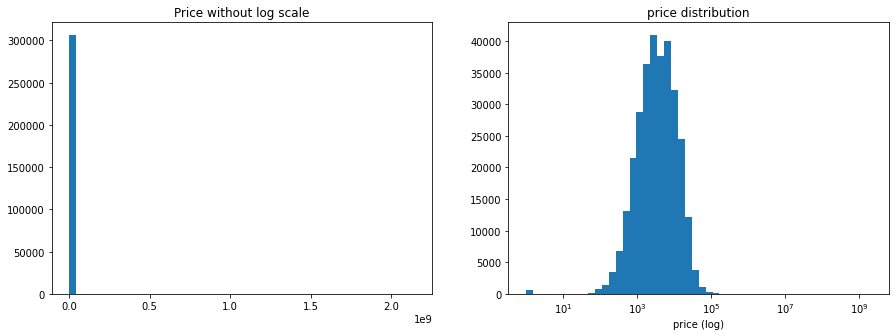

In [12]:
# Draw a histogram for price, however I know there are some extremely high values too such as 1000000 or 999999. So I will also plot a histogram with the log of price using the function above.
price = dataset['price']

plt.figure(figsize=(15,5))

# Histogram without logarithmic scale
plt.subplot(121)
hist, bins, a = plt.hist(x=price, bins=50)
plt.title("Price without log scale")
    
loghist(price, bins, 122)

In [13]:
# As can be seen from the log histogram, there is a small bar on the left of the scale that needs investigating. I will also take a look at the cars above 10^5 too.
# Let's display cars under $100
prunder_100 = dataset[dataset['price'] < 100]
prunder_100.head(15)

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
60,60,2016-03-29 15:48:15,TAUSCHE_BMW_E38_740i_g._SUV_/_GELÄNDEWAGEN_LES...,privat,Angebot,1,control,suv,1994,manuell,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
91,91,2016-03-28 09:37:01,MERCEDES_BENZ_W124_250D_83KW_/_113PS___SCHLACH...,privat,Angebot,1,control,limousine,1995,manuell,113,e_klasse,150000,4,diesel,mercedes_benz,nein,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
279,279,2016-03-12 07:26:49,Tausche_Youngtimer_Audi_80_mit_knapp_62000_km,privat,Angebot,1,test,limousine,1990,manuell,90,80,70000,6,benzin,audi,nein,2016-03-11 00:00:00,0,55122,2016-03-26 23:15:49
422,422,2016-03-29 18:51:58,Schlachte_Golf_4._89.000_KM._Blau_1.4_16V,privat,Angebot,1,control,NaN,2000,NaN,75,golf,90000,3,benzin,volkswagen,NaN,2016-03-29 00:00:00,0,78588,2016-04-06 04:45:50
985,985,2016-04-03 14:39:43,Suzuki_Swift_1.0__D3_Norm_eFh_bei_Berlin,privat,Angebot,98,test,kleinwagen,1997,manuell,53,swift,150000,7,benzin,suzuki,nein,2016-04-03 00:00:00,0,14542,2016-04-05 13:18:15
1011,1011,2016-03-23 08:21:11,Opel_Omega_B_Caravan_2_0__fahrbereit,privat,Angebot,1,test,kombi,1998,manuell,136,omega,150000,0,benzin,opel,nein,2016-03-22 00:00:00,0,57614,2016-03-27 08:45:52
1070,1070,2016-03-15 18:57:12,MX5_Mazda_NB_Schlachtfest__Reifen_Bremsen_Miat...,privat,Angebot,3,control,cabrio,1998,manuell,110,mx_reihe,150000,11,NaN,mazda,ja,2016-03-15 00:00:00,0,89312,2016-04-06 21:16:58
1708,1708,2016-03-13 03:36:19,Biete_IN_TEILEN_AN__Renault_Scenic_2__Benziner...,privat,Angebot,2,test,bus,2004,manuell,135,scenic,150000,0,benzin,renault,NaN,2016-03-13 00:00:00,0,30926,2016-04-02 15:17:36
1996,1996,2016-04-05 06:56:04,Leasinguebernahme_Jaguar_XF_3.0_V6_34.000_Rest...,privat,Angebot,1,test,limousine,2013,automatik,241,x_type,30000,9,diesel,jaguar,nein,2016-04-05 00:00:00,0,92660,2016-04-07 09:44:19
2278,2278,2016-03-10 23:56:22,TAUSCHE____BMW_E46_Compact_320td_gegen_anderen...,privat,Angebot,1,test,kleinwagen,2002,manuell,150,3er,150000,10,diesel,bmw,NaN,2016-03-10 00:00:00,0,83043,2016-04-06 02:44:33


As you can see, most of these car prices are not realistic. This is probably because there are a lot of bid prices included with the cars, where these low values could be the starting bid for a car or something similar. The histogram shows a relatively high amount of cars in the protruding bin to the left of the graph, which is lower than 100 EUR. I think it's best to remove all these values, as selling any car, no matter how bad it is, for 100 EUR is unrealistic anyway.

In [14]:
lowest_price = 100
dataset = dataset.drop(dataset[dataset['price'] < lowest_price].index)
dataset['price'].min()

100

In [15]:
# At the other end of the data there are also extreme outliers that may be mistakes of some sort. These are all values over 5million
over_ten_million = dataset[dataset['price'] > 5000000]
over_ten_million

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
14663,14663,2016-04-03 06:03:56,Tausch_moeglich_Polo_vw_n9,privat,Angebot,11111111,control,coupe,2003,manuell,64,polo,150000,2,benzin,volkswagen,NaN,2016-04-03 00:00:00,0,46535,2016-04-07 10:16:51
21467,21467,2016-03-19 19:45:02,Porsche_911_911R_1_of_20_ORIGINAL_R_nur_798KG!...,privat,Angebot,9999999,control,coupe,1967,manuell,215,911,50000,10,benzin,porsche,nein,2016-03-19 00:00:00,0,70435,2016-04-01 10:45:30
54295,54295,2016-03-08 11:51:40,Mazda_5_2.0_CD_DPF_Exclusive,privat,Angebot,10000000,control,bus,2007,manuell,143,5_reihe,150000,2,diesel,mazda,nein,2016-03-08 00:00:00,0,83301,2016-03-10 14:17:16
54507,54507,2016-03-09 11:40:15,Tausch_DKW_F8_gegen_Lanz_Bulldog,privat,Angebot,11111111,test,andere,1953,manuell,20,NaN,150000,5,NaN,audi,nein,2016-03-09 00:00:00,0,7774,2016-04-05 14:46:32
56973,56973,2016-03-18 18:52:27,tausche_ford_mondeo_mk3_ghia_gegen_anderes_auto,privat,Angebot,99999999,control,limousine,2002,manuell,131,mondeo,150000,1,NaN,ford,NaN,2016-03-18 00:00:00,0,27574,2016-03-18 18:52:27
77520,77520,2016-03-22 14:58:27,Tausch_gegen_gleichwertiges,privat,Angebot,99999999,control,limousine,1999,automatik,224,s_klasse,150000,9,benzin,mercedes_benz,NaN,2016-03-22 00:00:00,0,73525,2016-04-06 05:15:30
87799,87799,2016-03-08 20:39:05,Leasinguebernahme,privat,Angebot,27322222,control,limousine,2014,manuell,163,c4,40000,2,diesel,citroen,NaN,2016-03-08 00:00:00,0,76532,2016-03-08 20:39:05
91106,91106,2016-03-30 19:46:05,Verkaufe_oder_tausche_wenn_nur_gegen_Kombi_s4_...,privat,Angebot,9999999,test,limousine,1996,manuell,380,a4,60000,5,benzin,audi,nein,2016-03-30 00:00:00,0,47800,2016-03-30 19:46:05
127769,127769,2016-03-28 12:51:51,Golf_4_laesst_sich_nicht_oeffnen,privat,Angebot,11111111,test,limousine,2003,manuell,75,golf,125000,9,benzin,volkswagen,NaN,2016-03-28 00:00:00,0,38122,2016-03-30 03:18:00
127820,127820,2016-03-14 17:49:54,audi_a6_c5_avant,privat,Angebot,99999999,test,kombi,1999,manuell,165,a6,5000,12,benzin,audi,nein,2016-03-14 00:00:00,0,28325,2016-03-14 17:49:54


In [16]:
# Every single one of these cars is either a false price (like the mercedes benz clk coupe 280 7g tronic listed for 14million), or a random price (11111111, 99999999, etc), so I will drop all of these
dataset = dataset[dataset['price'] < 5000000]
dataset.shape

(304990, 21)

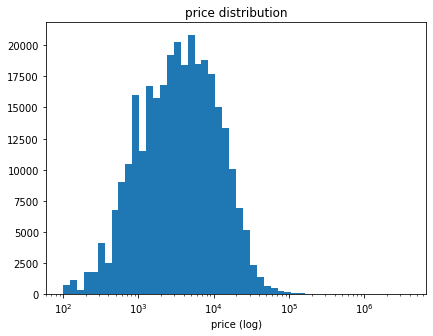

In [17]:
plt.figure(figsize=(15,5))
price = dataset['price']
hist, bins, a = plt.hist(x=price, bins=50)
loghist(price, bins, 122)

There are many more peculiar entries, but it would be impossible to go through 200,000+ rows finding oddities. However, through cleaning other features we will get rid of a lot of mistakes or rows that will make the model better without manipulating the data too much (as I have not split the data yet). I am only removing outliers which look like mistakes that are not representative of real life data. The next feature I will be checking for outliers is powerPS.

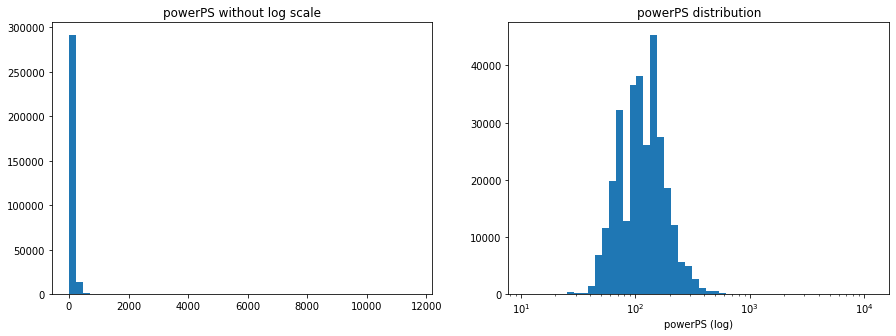

In [18]:
# Let's visualise the histogram for powerPS, with and without log scale
power = dataset['powerPS']
plt.figure(figsize=(15,5))

# Histogram without logarithmic scale
plt.subplot(121)
hist, bins, a = plt.hist(x=power, bins=50)
plt.title("powerPS without log scale")

loghist(power, bins, 122)

In [19]:
highest_PS = dataset[dataset['powerPS'] > 800]
highest_PS

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
69726,69726,2016-03-17 15:58:57,Oldtimer_Lkw,privat,Angebot,999999,test,andere,1960,manuell,9999,NaN,150000,0,NaN,mercedes_benz,NaN,2016-03-17 00:00:00,0,27616,2016-03-19 16:16:52
198557,198557,2016-03-12 12:45:04,Maserati_Indy_V8_4_2_ZF_5_Gang_Schaltgetriebe_...,privat,Angebot,75000,test,coupe,1969,manuell,3144,NaN,80000,8,benzin,sonstige_autos,nein,2016-03-07 00:00:00,0,63796,2016-04-06 10:15:49
237066,237066,2016-03-15 10:52:11,Verkaufe_oder_Taeusche_gegen_grosses_Auto,privat,Angebot,123456,control,limousine,2006,manuell,11620,golf,100000,5,benzin,volkswagen,nein,2016-03-15 00:00:00,0,22523,2016-04-05 20:46:50
279254,279254,2016-04-04 15:52:05,Mercedes_Benz_E_63_AMG_Performance_Package_JP_...,privat,Angebot,74990,test,limousine,2011,automatik,801,e_klasse,70000,4,benzin,mercedes_benz,nein,2016-04-04 00:00:00,0,59759,2016-04-06 17:44:45


In [20]:
dataset.drop([69726,198557,237066,279254], axis=0, inplace=True)

That's it for extreme outliers, as most of the features are nominal (including kilometer). It's time to split the dataset.

In [21]:
# Time to split the dataset
X = dataset
y = dataset['price']
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Remove or fill in missing values?
After splitting the dataset, it is time to work on cleaning and transforming the training dataset, and then go onto constructing the model based on the clean training data. The first steps are to fill in or remove missing values. To decide if we need to remove or fill in the values, we may need to do some visualisation and analysis to judge how the model will be affected depending on the action we take.

In [22]:
# Now I will deal with null values. I will get a look at the null %s in each column and decide to either drop those rows or fill in the missing values
df_train.isna().sum() * 100 / len(df_train)

index                   0.000000
dateCrawled             0.000000
name                    0.000000
seller                  0.000000
offerType               0.000000
price                   0.000000
abtest                  0.000000
vehicleType             1.536141
yearOfRegistration      0.000000
gearbox                 1.610325
powerPS                 0.000000
model                   3.507140
kilometer               0.000000
monthOfRegistration     0.000000
fuelType                4.245291
brand                   0.000000
notRepairedDamage      13.234667
dateCreated             0.000000
nrOfPictures            0.000000
postalCode              0.000000
lastSeen                0.000000
dtype: float64

<AxesSubplot:xlabel='notRepairedDamage', ylabel='count'>

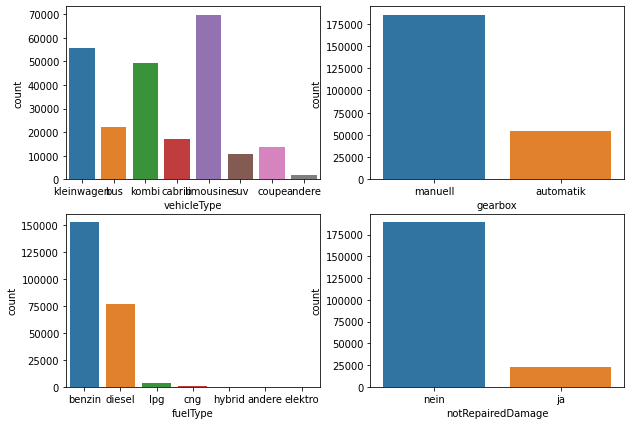

In [23]:
# See the frequency distribution of each category with missing values (apart from model, I will come back to this later)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,7))  
sns.countplot(data=df_train, x='vehicleType', ax=ax1)
sns.countplot(data=df_train, x='gearbox', ax=ax2)
sns.countplot(data=df_train, x='fuelType', ax=ax3)
sns.countplot(data=df_train, x='notRepairedDamage', ax=ax4)

Where I can, I want to try to avoid removing data. For example, vehicleType has 1.5% null values, which is a few thousand cars in this dataset. First, the most common method to fill in missing data in categorical features like this is using the mode. If the mode is not suitable, I will drop the entries instead.

<AxesSubplot:xlabel='notRepairedDamage', ylabel='price'>

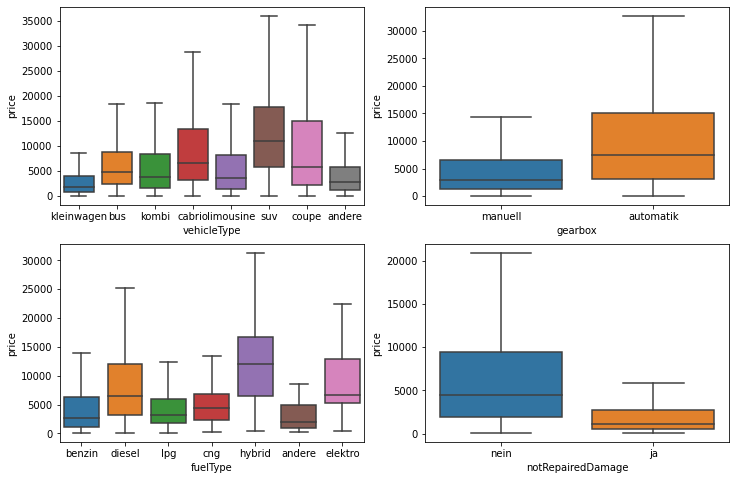

In [24]:
# Boxplots for each of these variables
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))
sns.boxplot(data=df_train, y='price', x='vehicleType', showfliers=False, orient='v', ax=ax1)
sns.boxplot(data=df_train, y='price', x='gearbox', showfliers=False, orient='v', ax=ax2)
sns.boxplot(data=df_train, y='price', x='fuelType', showfliers=False, orient='v', ax=ax3)
sns.boxplot(data=df_train, y='price', x='notRepairedDamage', showfliers=False, orient='v', ax=ax4)

From what it looks like, each class in each variable has very differing ranges and IQR's. Let's analyse the modes for each feature. The mode for vehicleType is limousine (which is sedan in german according to Google translate), and we see that limousine has a smaller range and IQR than majority of the other classes. This means that if we were to fill every missing value with limousine, the price predicted will be generally lower than if we filled in with something like SUV. Even though the chances that the car was actually a sedan is higher than other classes, there is still a big chance that the car is actually a compact car ('kleinwagen') or a van-like car ('kombi').

All the same can be said about gearbox and fuelType. The solution here is to just drop all the missing values for these three variables. This dataset also has a lot of data already, so losing these cars will not affect the model too much.

As for notRepairedDamage, the decision to drop values is unclear. We can see that the frequency of 'nein' is extraordinarily higher than 'ja'. This means that most cars will have no damage that isn't repaired. Even though the range, IQR and the median of 'ja' cars is much lower than 'nein', only a select few cars will be incorrectly filled in as 'nein' anyways. If this feature had a low null percentage like the other ones (0-5%), I would consider dropping these. However, I do not want to lose 13% of the data, and these cars are most likely 'nein'. herefore, for this feature I can fill in the missing values with 'nein' and it will not make predictions that much worse (hopefully).

In [25]:
# function to remove rows with missing values from a given column
def del_rows(df, *columns):
    for c in columns:
        df = df.dropna(subset=[c])
    return df

In [26]:
# Remove rows with missing model values
df_train = del_rows(df_train, 'vehicleType', 'gearbox', 'fuelType')
df_train.shape

(228722, 21)

In [27]:
# Fill in notRepairedDamage
df_train['notRepairedDamage'] = df_train['notRepairedDamage'].fillna(df_train['notRepairedDamage'].mode()[0])

In [28]:
df_train = del_rows(df_train, 'model')

In [29]:
df_train.isna().sum()

index                  0
dateCrawled            0
name                   0
seller                 0
offerType              0
price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dateCreated            0
nrOfPictures           0
postalCode             0
lastSeen               0
dtype: int64

## Looking for correlations
Here I will be looking for features that correlate with the price or with each other (mainly using data visualisation)

In [30]:
# Check correlations between numerical variables and price
corr = df_train.corr()
corr['price'].sort_values()

kilometer             -0.352420
index                 -0.003245
monthOfRegistration    0.020688
postalCode             0.053685
yearOfRegistration     0.324225
powerPS                0.463473
price                  1.000000
nrOfPictures                NaN
Name: price, dtype: float64

powerPS & yearOfRegistration are moderately positively correlated, whereas kilometer (mileage) is negatively correlated with around the same magnitude.
Let's visualise these using pandas' scatter_matrix function, which will plot every numerical attribute against each other (we will get 16 plots).
Since there are very few points in 'price' that are over 50,000 (relative to the entire dataset), I will exclude these values (I won't be removing them from the dataset, just from the visualisations) for the purpose of showing relationships for majority of the data. 

<AxesSubplot:xlabel='yearOfRegistration', ylabel='Count'>

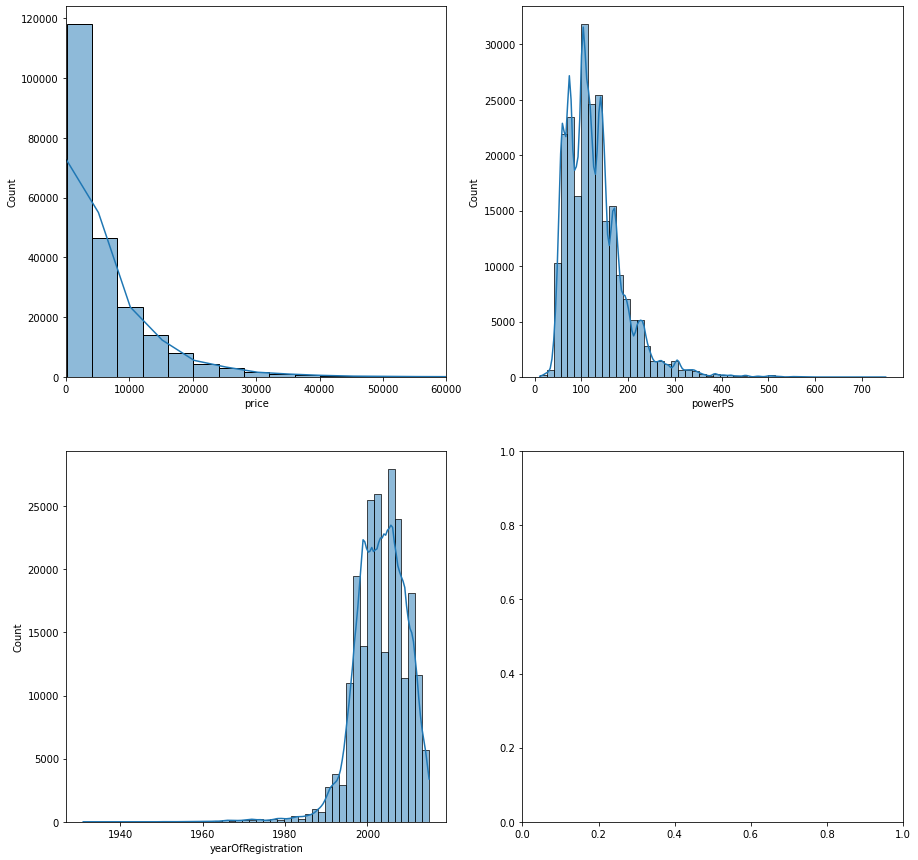

In [31]:
# Histograms to check distribution of these variables
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(15,15))
ax1.set_xlim(0,60000)
sns.histplot(data=df_train, x='price', bins=250, kde=True, ax=ax1)
sns.histplot(data=df_train, x='powerPS', bins=50, kde=True, ax=ax2)
sns.histplot(data=df_train, x='yearOfRegistration', bins=50, kde=True, ax=ax3)

array([[<AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='powerPS', ylabel='price'>,
        <AxesSubplot:xlabel='yearOfRegistration', ylabel='price'>,
        <AxesSubplot:xlabel='kilometer', ylabel='price'>],
       [<AxesSubplot:xlabel='price', ylabel='powerPS'>,
        <AxesSubplot:xlabel='powerPS', ylabel='powerPS'>,
        <AxesSubplot:xlabel='yearOfRegistration', ylabel='powerPS'>,
        <AxesSubplot:xlabel='kilometer', ylabel='powerPS'>],
       [<AxesSubplot:xlabel='price', ylabel='yearOfRegistration'>,
        <AxesSubplot:xlabel='powerPS', ylabel='yearOfRegistration'>,
        <AxesSubplot:xlabel='yearOfRegistration', ylabel='yearOfRegistration'>,
        <AxesSubplot:xlabel='kilometer', ylabel='yearOfRegistration'>],
       [<AxesSubplot:xlabel='price', ylabel='kilometer'>,
        <AxesSubplot:xlabel='powerPS', ylabel='kilometer'>,
        <AxesSubplot:xlabel='yearOfRegistration', ylabel='kilometer'>,
        <AxesSubplot:xlabel='kilometer', yl

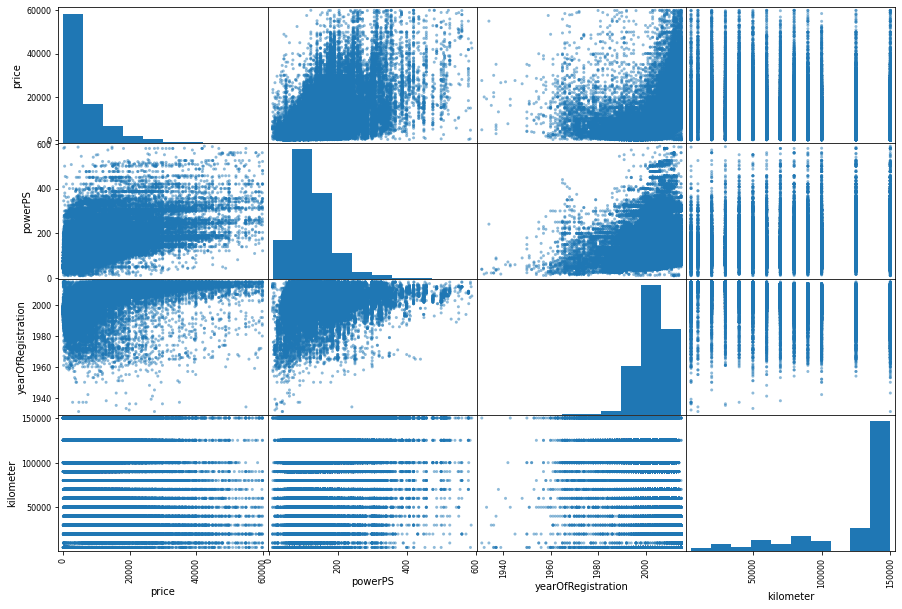

In [32]:
# Copy of df_train to visualise
df = df_train.copy()
df = df[df['price'] < 60000]

scatter_variables = ['price', 'powerPS', 'yearOfRegistration', 'kilometer']
scatter_matrix(df[scatter_variables], figsize=(15,10))

The most interesting relationships are between yearOfRegistration & price, powerPS & price, and powerPS & yearOfRegistration. There is an over-plotting problem which makes it hard to exactly spot patterns in the data. Plotting these three graphs (and kilometer against price) with better visualisation.

<AxesSubplot:title={'center':'kilometer against (log) price'}, xlabel='kilometer', ylabel='price'>

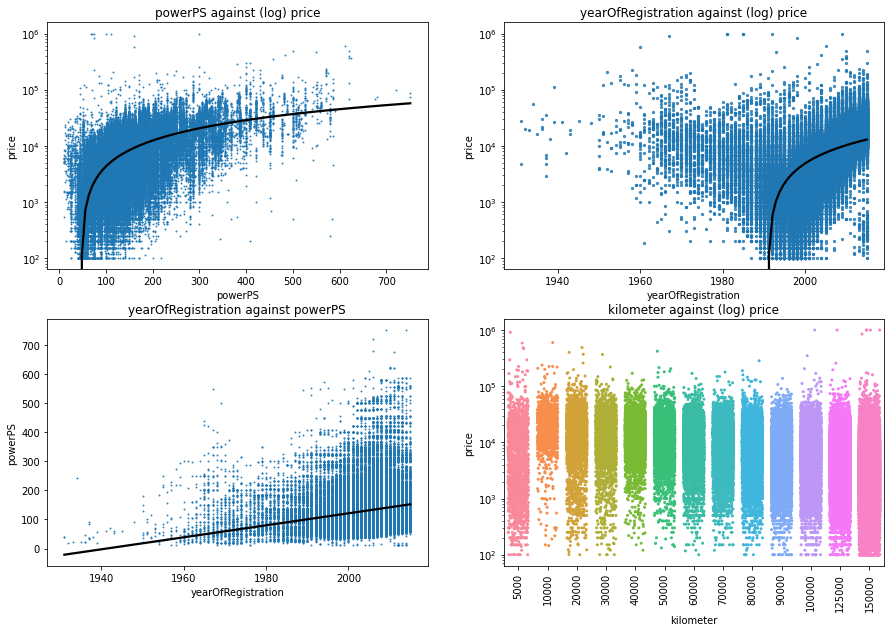

In [33]:
# Plot log graph for powerPS against price. In this plot, the distribution is greatly positively skewed, as majority of the cars are low power and low price. Therefore, I will use a log scale for price
# I am also using the original dataset (df_train) instead of the limited one (df)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))

ax1.set_yscale('log')
ax1.set_title('powerPS against (log) price')
sns.regplot(x='powerPS', y='price', data=df_train, scatter_kws={'s': 1}, line_kws={'color': 'black'}, ax=ax1, ci=None)

ax2.set_title('yearOfRegistration against (log) price')
ax2.set_yscale('log')
sns.regplot(x='yearOfRegistration', y='price', data=df_train, ax=ax2, scatter_kws={'s':5}, line_kws={'color': 'black'}, ci=None)

ax3.set_title('yearOfRegistration against powerPS')
sns.regplot(x='yearOfRegistration', y='powerPS', data=df_train, ax=ax3, scatter_kws={'s': 1}, line_kws={'color': 'black'}, ci=None)

ax4.set_title('kilometer against (log) price')
ax4.set_yscale('log')
ax4.tick_params(axis='x', rotation=90)
sns.stripplot(data=df_train, x='kilometer', y='price', jitter=0.35, size=3, ax=ax4)

<AxesSubplot:title={'center':'box plot for yearOfRegistration against price'}, xlabel='yearOfRegistration', ylabel='price'>

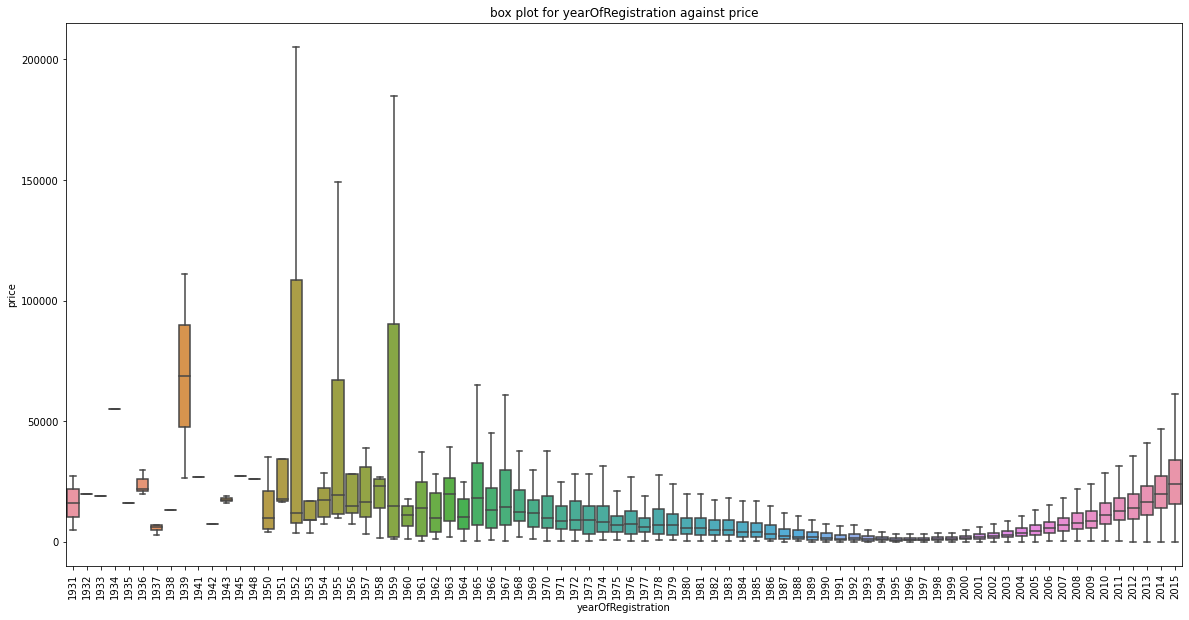

In [34]:
# A better way to see the trend of yearOfRegistration against price
plt.figure(figsize=(20,10))
plt.tick_params(axis='x', rotation=90)
plt.title('box plot for yearOfRegistration against price')
sns.boxplot(data=df_train, x='yearOfRegistration', y='price', showfliers=False)

From around 1995, as cars get newer, the median, IQR and range of price of cars get exponentially higher. Also from 1995, older cars tend to start increasing in price. Although their range gets higher quickly, the median does not get higher as quickly as newer cars do. This suggests that older cars (pre-1995) can go for a lot, but majority of them do not. This is most likely because out of older cars, only few will be 'rare' and worth the money, while most of the cars will just be old and cheap. It is apparent that there is not enough data on the really old cars, which can be seen by the unstable and random box plots before 1961.

## Feature Engineering

### New features for high cardinality features and encoding
To see the correlations between categorical variables and price (or each other), I will need to encode these variables. The features I will be working on are vehicleType, gearbox, model, fuelType, brand, notRepairedDamage.  
Model has 250 unique values, so I will deal with this more specifically after encoding the others.  
'seller' and 'offerType' are near zero variance predictors, and so they do not need any looking further into.  
Brand and model are high cardinality data (especially model) so I will work on them seperately.  
Starting with model, I will put every unique model that only appears less than 100 times into the 'andere' category. Then, I'll find the mean price for each model for a new category and subtract the global mean for model from each mean and use that instead of 'model'. The same will be done to brand too.  
This way, we can keep dimenstionality low while also having a numerical variable for models. For the 'andere' model, since it is likely to have very high variance and a lot of outliers, I can use the mean price of the brand instead.

In [35]:
# Put all models that appear 100 times or under in other category
def make_andere(data, cat):
    under_100 = data[cat].value_counts() <= 100
    under_100 = list(under_100[under_100 == True].index)
    data[cat] = data[cat].replace(under_100, 'andere')

In [36]:
make_andere(df_train, 'model')

In [37]:
df_train.head()

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
259826,259826,2016-03-27 19:45:29,VW_Polo_1_2,privat,Angebot,2499,control,kleinwagen,2003,manuell,64,polo,150000,5,benzin,volkswagen,nein,2016-03-27 00:00:00,0,58509,2016-04-06 09:46:03
72694,72694,2016-03-22 14:25:18,Mercedes_Benz_B_180_CDI__BlueEFFICIENCY__7G_DCT,privat,Angebot,17200,control,bus,2012,automatik,109,b_klasse,70000,5,diesel,mercedes_benz,nein,2016-03-22 00:00:00,0,57299,2016-03-23 14:37:43
165162,165162,2016-03-07 21:50:37,Opel_omega,privat,Angebot,1800,control,kombi,1997,manuell,116,omega,150000,0,benzin,opel,nein,2016-03-07 00:00:00,0,65510,2016-03-09 18:29:18
49888,49888,2016-03-28 14:45:18,Volkswagen_Polo_Variant_75_Comfortline,privat,Angebot,1790,test,kombi,1998,manuell,75,polo,150000,12,benzin,volkswagen,nein,2016-03-28 00:00:00,0,87616,2016-04-06 18:45:25
238657,238657,2016-03-25 00:55:47,Ford_Fiesta_1.4_Sport,privat,Angebot,6499,control,kleinwagen,2009,manuell,97,fiesta,50000,12,benzin,ford,nein,2016-03-25 00:00:00,0,9113,2016-04-04 03:47:28


In [38]:
# Create new feature model_mean_prices
model_mean_prices = df_train.groupby('model').mean().price
model_mean_global = model_mean_prices.mean()
df_train['model_price_lift'] = df_train['model'].map(model_mean_prices)
df_train['model_price_lift'] -= model_mean_global
df_train.head()

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,model_price_lift
259826,259826,2016-03-27 19:45:29,VW_Polo_1_2,privat,Angebot,2499,control,kleinwagen,2003,manuell,64,polo,150000,5,benzin,volkswagen,nein,2016-03-27 00:00:00,0,58509,2016-04-06 09:46:03,-4621.600100
72694,72694,2016-03-22 14:25:18,Mercedes_Benz_B_180_CDI__BlueEFFICIENCY__7G_DCT,privat,Angebot,17200,control,bus,2012,automatik,109,b_klasse,70000,5,diesel,mercedes_benz,nein,2016-03-22 00:00:00,0,57299,2016-03-23 14:37:43,3066.764687
165162,165162,2016-03-07 21:50:37,Opel_omega,privat,Angebot,1800,control,kombi,1997,manuell,116,omega,150000,0,benzin,opel,nein,2016-03-07 00:00:00,0,65510,2016-03-09 18:29:18,-6529.684387
49888,49888,2016-03-28 14:45:18,Volkswagen_Polo_Variant_75_Comfortline,privat,Angebot,1790,test,kombi,1998,manuell,75,polo,150000,12,benzin,volkswagen,nein,2016-03-28 00:00:00,0,87616,2016-04-06 18:45:25,-4621.600100
238657,238657,2016-03-25 00:55:47,Ford_Fiesta_1.4_Sport,privat,Angebot,6499,control,kleinwagen,2009,manuell,97,fiesta,50000,12,benzin,ford,nein,2016-03-25 00:00:00,0,9113,2016-04-04 03:47:28,-4768.090831


In [39]:
# Replace the mean value of 'andere' models with the mean for the brand instead
brand_mean_prices = df_train.groupby('brand').mean().price
andere_models = df_train[df_train['model'] == 'andere']
andere_models['model_price_lift'] = andere_models['brand'].map(brand_mean_prices)
andere_models['model_price_lift'] -= model_mean_global
andere_models.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,model_price_lift
126689,126689,2016-03-30 20:44:24,Mazda_2_1.3_MZR_Sendo,privat,Angebot,9300,control,kleinwagen,2014,manuell,84,andere,30000,10,benzin,mazda,nein,2016-03-30 00:00:00,0,91452,2016-04-07 12:36:40,-3221.747491
45400,45400,2016-04-01 19:51:37,Mercedes_Benz_Vaneo_1.6_Ambiente_Unfallfrei_Sc...,privat,Angebot,2490,control,bus,2003,manuell,102,andere,150000,6,benzin,mercedes_benz,nein,2016-04-01 00:00:00,0,45327,2016-04-01 19:51:37,1407.271206
279165,279165,2016-03-28 17:47:31,skoda_rapid_spacebak,privat,Angebot,15000,test,kombi,2015,manuell,105,andere,30000,3,benzin,skoda,nein,2016-03-28 00:00:00,0,84069,2016-04-06 23:45:09,-914.439762
269876,269876,2016-03-10 17:53:40,Fiat_Palio_Weekend,privat,Angebot,800,control,kombi,2001,manuell,73,andere,150000,6,benzin,fiat,ja,2016-03-10 00:00:00,0,89520,2016-03-12 08:44:27,-4532.906507
53827,53827,2016-03-11 09:37:17,Hyundai_Artos_Prime_Amica,privat,Angebot,1300,control,kleinwagen,2000,manuell,54,andere,150000,6,benzin,hyundai,ja,2016-03-11 00:00:00,0,67705,2016-04-06 21:47:42,-1675.864496


In [40]:
df_train.update(andere_models)

In [41]:
# Add new column for mean prices for brand subtract global mean price for brand
brand_mean_global = brand_mean_prices.mean()
df_train['brand_price_lift'] = df_train['brand'].map(brand_mean_prices)
df_train['brand_price_lift'] -= brand_mean_global
df_train.head()

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,model_price_lift,brand_price_lift
259826,259826.0,2016-03-27 19:45:29,VW_Polo_1_2,privat,Angebot,2499.0,control,kleinwagen,2003.0,manuell,64.0,polo,150000.0,5.0,benzin,volkswagen,nein,2016-03-27 00:00:00,0.0,58509.0,2016-04-06 09:46:03,-4621.600100,-662.533294
72694,72694.0,2016-03-22 14:25:18,Mercedes_Benz_B_180_CDI__BlueEFFICIENCY__7G_DCT,privat,Angebot,17200.0,control,bus,2012.0,automatik,109.0,b_klasse,70000.0,5.0,diesel,mercedes_benz,nein,2016-03-22 00:00:00,0.0,57299.0,2016-03-23 14:37:43,3066.764687,2438.869239
165162,165162.0,2016-03-07 21:50:37,Opel_omega,privat,Angebot,1800.0,control,kombi,1997.0,manuell,116.0,omega,150000.0,0.0,benzin,opel,nein,2016-03-07 00:00:00,0.0,65510.0,2016-03-09 18:29:18,-6529.684387,-3404.804902
49888,49888.0,2016-03-28 14:45:18,Volkswagen_Polo_Variant_75_Comfortline,privat,Angebot,1790.0,test,kombi,1998.0,manuell,75.0,polo,150000.0,12.0,benzin,volkswagen,nein,2016-03-28 00:00:00,0.0,87616.0,2016-04-06 18:45:25,-4621.600100,-662.533294
238657,238657.0,2016-03-25 00:55:47,Ford_Fiesta_1.4_Sport,privat,Angebot,6499.0,control,kleinwagen,2009.0,manuell,97.0,fiesta,50000.0,12.0,benzin,ford,nein,2016-03-25 00:00:00,0.0,9113.0,2016-04-04 03:47:28,-4768.090831,-2559.567257


In [42]:
# Make new df of useful features
features = ['price', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'kilometer', 'fuelType', 'notRepairedDamage', 'model_price_lift', 'brand_price_lift']
train_y = df_train['price']
train_x = df_train[features]
train_x.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,fuelType,notRepairedDamage,model_price_lift,brand_price_lift
259826,2499.0,kleinwagen,2003.0,manuell,64.0,150000.0,benzin,nein,-4621.600100,-662.533294
72694,17200.0,bus,2012.0,automatik,109.0,70000.0,diesel,nein,3066.764687,2438.869239
165162,1800.0,kombi,1997.0,manuell,116.0,150000.0,benzin,nein,-6529.684387,-3404.804902
49888,1790.0,kombi,1998.0,manuell,75.0,150000.0,benzin,nein,-4621.600100,-662.533294
238657,6499.0,kleinwagen,2009.0,manuell,97.0,50000.0,benzin,nein,-4768.090831,-2559.567257


### Encoding
Using get_dummies is not ideal for modelling because it does not account for unseen data (which is the test set will have). OneHotEncoder is used for encoding the data in the actual model, but I will use get_dummies just to see the correlations and draw a heatmap of our new features and encoded ones.

In [43]:
# get_dummies to check correlations, then OneHotEncoder for the models
dummies_df = pd.get_dummies(train_x)
corrs = dummies_df.corr()
corrs['price'].sort_values()

kilometer                -0.352420
gearbox_manuell          -0.236187
vehicleType_kleinwagen   -0.178387
fuelType_benzin          -0.155686
notRepairedDamage_ja     -0.113977
fuelType_lpg             -0.025704
vehicleType_andere       -0.015655
vehicleType_kombi        -0.015534
vehicleType_limousine    -0.014397
fuelType_cng             -0.005783
fuelType_andere          -0.004350
fuelType_elektro          0.002174
vehicleType_bus           0.015689
fuelType_hybrid           0.019206
vehicleType_cabrio        0.109558
vehicleType_coupe         0.113001
notRepairedDamage_nein    0.113977
vehicleType_suv           0.146823
fuelType_diesel           0.163912
gearbox_automatik         0.236187
yearOfRegistration        0.324225
brand_price_lift          0.367705
powerPS                   0.463473
model_price_lift          0.489968
price                     1.000000
Name: price, dtype: float64

In [44]:
features_df = dummies_df.drop(['price'], axis=1)
features_corrs = features_df.corr()

<AxesSubplot:>

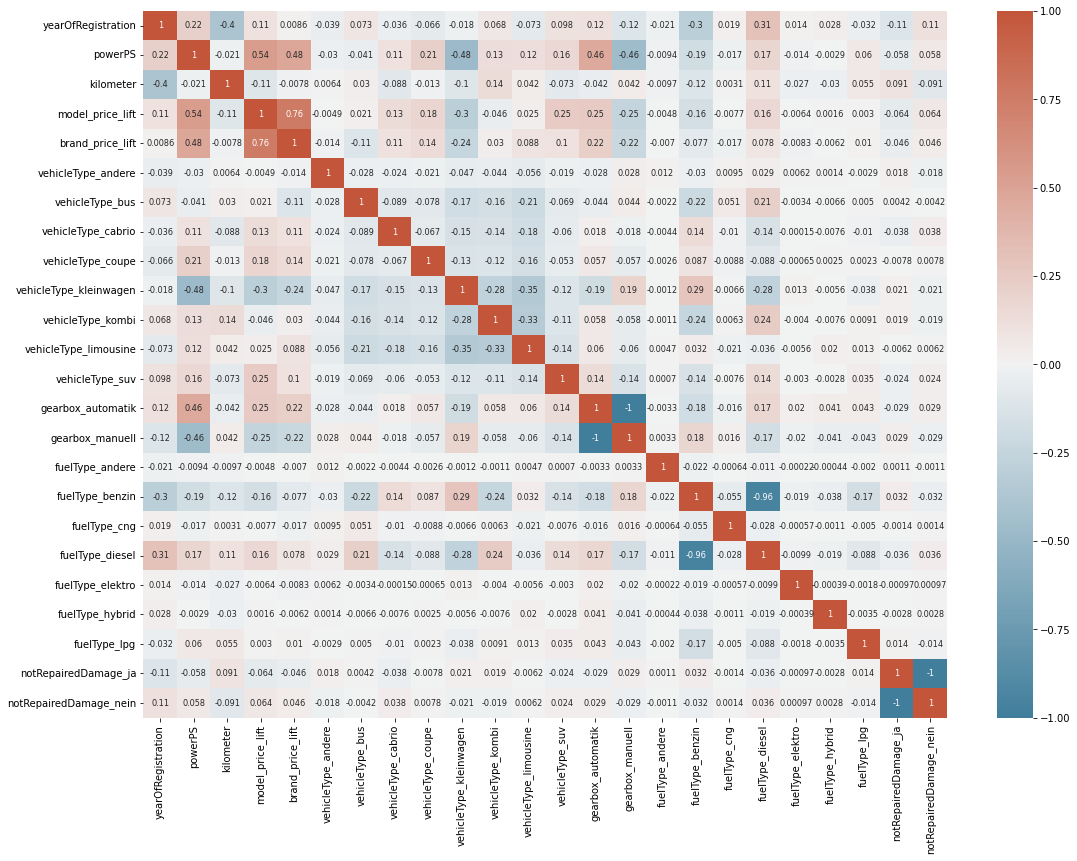

In [45]:
plt.figure(figsize=(18,13))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(features_corrs, cmap=cmap, annot=True, annot_kws={"size": 40 / np.sqrt(len(features_corrs))})

In [46]:
train_x.drop('price', axis=1, inplace=True)
train_x.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,fuelType,notRepairedDamage,model_price_lift,brand_price_lift
259826,kleinwagen,2003.0,manuell,64.0,150000.0,benzin,nein,-4621.600100,-662.533294
72694,bus,2012.0,automatik,109.0,70000.0,diesel,nein,3066.764687,2438.869239
165162,kombi,1997.0,manuell,116.0,150000.0,benzin,nein,-6529.684387,-3404.804902
49888,kombi,1998.0,manuell,75.0,150000.0,benzin,nein,-4621.600100,-662.533294
238657,kleinwagen,2009.0,manuell,97.0,50000.0,benzin,nein,-4768.090831,-2559.567257


In [47]:
col_transformer = make_column_transformer((OneHotEncoder(), ['vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage']), remainder='passthrough')

In [48]:
transformed_x = pd.DataFrame(col_transformer.fit_transform(train_x))

In [49]:
# Reduce memory usage after encoding
print('-' * 80)
print('transformed_x')
transformed_x = reduce_mem_usage(transformed_x)
print('-' * 80)

--------------------------------------------------------------------------------
transformed_x
Memory usage of dataframe is 40.73 MB
Memory usage after optimization is: 10.61 MB
Decreased by 74.0%
--------------------------------------------------------------------------------


# Modelling